# Petals to the Metal Competition Submission #

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
    <strong>Group 11</strong><br>
Shailja Kartik, Xinyu Li, Paul Mello, and Rodrigo Teixeira
</blockquote>

# 1. Imports #

In [1]:
# Installing efficientnet
!pip install -q efficientnet

# Importing necessary libraries

# Misc.
import math, re, os
import random
import plotly.express as px
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

# Tensorflow
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
#tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau # LR_Scheduler

# Data / Evaluations
from kaggle_datasets import KaggleDatasets
import efficientnet.tfkeras as efn
from tensorflow.keras.applications import DenseNet201, Xception, ResNet101V2
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

print("Tensorflow version " + tf.__version__)

2022-05-12 04:00:17.668350: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-05-12 04:00:17.668507: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tensorflow version 2.4.1


In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

# Uncomment statement above to print all files

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

# 2. Defining Distribution Strategy #

We'll use the distribution strategy when we create our neural network model. Then, TensorFlow will distribute the training among the eight TPU cores by creating eight different replicas of the model, one for each core.

In [3]:
# Detect TPU, return appropriate distribution strategy
try:
    
    # TPUs are network-connected accelerators. TPUClusterResolver() locates them on the network.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    # Configuring the tpu for this object to contain the necessary distributed training code that will work on TPUs with their 8 compute cores
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    # Defining TPUStrategy by instantiating the model in the scope of the strategy. 
    # This creates the model on the TPU.
    # Model size is constrained by the TPU RAM only, not by the amount of memory available on the VM running your Python code. 
    # Model creation and model training use the usual Keras APIs.
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

2022-05-12 04:00:24.603264: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-12 04:00:24.606942: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-05-12 04:00:24.606979: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-12 04:00:24.607013: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b11f496f6e0f): /proc/driver/nvidia/version does not exist
2022-05-12 04:00:24.609914: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Running on TPU  grpc://10.0.0.2:8470


2022-05-12 04:00:30.166217: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-05-12 04:00:30.166295: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2022-05-12 04:00:30.169669: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-05-12 04:00:30.169714: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


REPLICAS:  8


# 3. Loading Data sets #

### Getting the GCS Path ###

We will retrieve the Google Cloud Storage bucket (GCS) path to get our datasets.

In [4]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
# Printing the GCS path for this dataset
print(GCS_DS_PATH)

gs://kds-459512293f4f03b3d21afa55d0f57a7c6bf09fe9d90171208872bdb3


### Setting Variables ###

In [5]:
''' TPUs are equipped with 128GB of high-speed memory allowing larger batches, larger models and also larger training inputs. 
In the code below, we can use 512x512 px input images, also provided in the dataset, and see the TPU v3-8 handle them easily.'''

VAL = 512
IMAGE_SIZE = [VAL, VAL]

AUTO = tf.data.experimental.AUTOTUNE

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 103

When used with TPUs, datasets are often serialized into TFRecords. 
This is a format convenient for distributing data to each of the TPUs cores. 
Source: https://www.kaggle.com/docs/tpu

In [6]:
GCS_DS_PATH_EXT = KaggleDatasets().get_gcs_path('tf-flower-photo-tfrec')

# External data
GCS_PATH_SELECT_EXT = {
    192: '/tfrecords-jpeg-192x192',
    224: '/tfrecords-jpeg-224x224',
    331: '/tfrecords-jpeg-331x331',
    512: '/tfrecords-jpeg-512x512'
}

GCS_PATH_EXT = GCS_PATH_SELECT_EXT[IMAGE_SIZE[0]]

GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-512x512'

### Loading the Data ###

In [7]:
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

IMAGENET_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/imagenet' + GCS_PATH_EXT + '/*.tfrec')
INATURELIST_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/inaturalist' + GCS_PATH_EXT + '/*.tfrec')
OPENIMAGE_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/openimage' + GCS_PATH_EXT + '/*.tfrec')
OXFORD_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/oxford_102' + GCS_PATH_EXT + '/*.tfrec')
TENSORFLOW_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/tf_flowers' + GCS_PATH_EXT + '/*.tfrec')

2022-05-12 04:00:40.886101: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-05-12 04:00:40.980087: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-05-12 04:00:41.066310: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-05-12 04:00:41.143059: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-05-12 04:00:41.316835: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [8]:
ADDITIONAL_TRAINING_FILENAMES = IMAGENET_FILES + INATURELIST_FILES + OPENIMAGE_FILES + OXFORD_FILES + TENSORFLOW_FILES  

TRAINING_FILENAMES = TRAINING_FILENAMES + ADDITIONAL_TRAINING_FILENAMES

### Unpacking Data ###

In [9]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    '''experimental_deterministic = False disables data order enforcement. 
    We will be shuffling the data anyway so order is not important. 
    With this setting the API can use any TFRecord as soon as it is streamed in.'''
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed.

    # num_parallel_reads=AUTO instructs the API to read from multiple files if available. It figures out how many automatically.
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files.
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

# 4. Data Augmentation #

Here we preform any data augmentation techiniques we see fit to improve model generalization.

### Random Erasing ###

Note 9 😀
Use additional data, tuning6, private dataset
Inspired by Dmitry's notebook here and Araik's notebook here
See also external data and how to use them and Kirill's tf_flower_photo_tfrec dataset

In [10]:
def random_blockout(img, sl=0.1, sh=0.2, rl=0.4):
    p=random.random()
    if p>=0.25:
        w, h, c = IMAGE_SIZE[0], IMAGE_SIZE[1], 3
        origin_area = tf.cast(h*w, tf.float32)

        e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * rl)), tf.int32)
        e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh / rl)), tf.int32)

        e_height_h = tf.minimum(e_size_h, h)
        e_width_h = tf.minimum(e_size_h, w)

        erase_height = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tf.int32)
        erase_width = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tf.int32)

        erase_area = tf.zeros(shape=[erase_height, erase_width, c])
        erase_area = tf.cast(erase_area, tf.uint8)

        pad_h = h - erase_height
        pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
        pad_bottom = pad_h - pad_top

        pad_w = w - erase_width
        pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
        pad_right = pad_w - pad_left

        erase_mask = tf.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
        erase_mask = tf.squeeze(erase_mask, axis=0)
        erased_img = tf.multiply(tf.cast(img,tf.float32), tf.cast(erase_mask, tf.float32))

        return tf.cast(erased_img, img.dtype)
    else:
        return tf.cast(img, img.dtype)

### Image Flipping / Cropping ###

Note 8 😀
Perform data augmentation, tuning4
Inspired by Dmitry's notebook here

In [11]:
def data_augment_v2(image, label):
    # Thanks to the dataset.prefetch(AUTO) statement in the next function (below), this happens essentially for free on TPU. 
    # Data pipeline code is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.
    
    flag = random.randint(1, 3)
    rand1 = random.randint(60, 90) * 0.01
    rand2 = random.randint(60, 90) * 0.01
    
    if flag == 1:
        image = tf.image.random_flip_left_right(image)
    elif flag == 2:
        image = tf.image.random_flip_up_down(image)
    else:
        image = tf.image.random_crop(image, [int(IMAGE_SIZE[0] * rand1), int(IMAGE_SIZE[0] * rand2), 3])

    image = random_blockout(image) 
    image = tf.image.resize(image, (VAL, VAL))   
    
    return image, label 

### Variety of Pixel Augmentations ###

Perform data augmentation, tuning7
Inspired by Xuanzhi Huang and Rahul Paul's notebook here

In [12]:
# Randomly make some changes to the images and return the new images and labels
def data_augment_v3(image, label):
    
    # Randomly resize and then crop images
    image = tf.image.resize(image, [720, 720])
    image = tf.image.random_crop(image, [VAL, VAL, 3])

    # Randomly reset brightness of images
    image = tf.image.random_brightness(image, 0.6)
    
    # Randomly reset saturation of images
    image = tf.image.random_saturation(image, 3, 5)
        
    # Randomly reset contrast of images
    image = tf.image.random_contrast(image, 0.3, 0.5)

    # Randomly reset hue of images, but this will make the colors really weird, which we think will not happen
    # in common photography
    # image = tf.image.random_hue(image, 0.5)
    
    # Blur images
    image = tfa.image.mean_filter2d(image, filter_shape = 10)
    
    # Randomly flip images
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    # Fail to rotate and transform images due to some bug in TensorFlow
    # angle = random.randint(0, 180)
    # image = tfa.image.rotate(image, tf.constant(np.pi * angle / 180))
    # image = tfa.image.transform(image, [1.0, 1.0, -250, 0.0, 1.0, 0.0, 0.0, 0.0])
    
    return image, label

In [13]:
def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO) statement in the next function (below), this happens essentially for free on TPU. 
    # Data pipeline code is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

# Additional DATA Augmentation code (not used as of now for version-9)
def data_augment_contrast(image, label ):    
    image = tf.image.random_contrast(image, 0.7, 1 )     
    image = tf.image.random_flip_up_down(image)    
    image = tf.image.random_flip_left_right(image)    
    return image, label

def data_augment_brightness(image, label):    
    image = tf.image.random_brightness(image, 1)    
    image = tf.image.random_flip_up_down(image)    
    image = tf.image.random_flip_left_right(image)    
    return image, label

def data_augment_saturation(image, label):    
    image = tf.image.random_saturation(image, 5, 10)    
    image = tf.image.random_flip_up_down(image)    
    image = tf.image.random_flip_left_right(image)    
    return image, label

def data_augment_crop(image, label):    
    image = tf.image.random_crop(value = image, size = [180, 180, 3] )    
    image = tf.image.random_flip_up_down(image)     
    image = tf.image.random_flip_left_right(image)     
    image = tf.image.resize(image, (VAL, VAL))    
    return image, label

In [14]:
# Old version of get_training_dataset, changed below by Rodrigo
'''def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO) #tuning4
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset'''

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO) #tuning4    
    #ds_contrast = dataset.map( data_augment_contrast, num_parallel_calls = AUTO)
    #ds_brightness = dataset.map( data_augment_brightness, num_parallel_calls = AUTO)
    #ds_saturation = dataset.map( data_augment_saturation, num_parallel_calls = AUTO)
    #ds_crop = dataset.map( data_augment_crop, num_parallel_calls = AUTO)
    #dataset = dataset.concatenate( ds_contrast ).concatenate( ds_brightness ).concatenate( ds_saturation ).concatenate( ds_crop )    
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset_with_id(ordered=False):
    dataset = load_dataset_with_id(VALIDATION_FILENAMES, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [15]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 68094 training images, 3712 validation images, 7382 unlabeled test images


Original Data: Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images <br>
Additional Data: Dataset: 68094 training images, 3712 validation images, 7382 unlabeled test images <br> <br>
This next cell will create the datasets that we'll use with Keras during training and inference. Notice how we scale the size of the batches to the number of TPU cores.

Note 3 😀
1. To go fast on a TPU, increase the batch size. The rule of thumb is to use batches of 128 elements per core (ex: batch size of 128*8=1024 for a TPU with 8 cores). At this size, the 128x128 hardware matrix multipliers of the TPU (see hardware section below) are most likely to be kept busy. You start seeing interesting speedups from a batch size of 8 per core though. In the sample above, the batch size is scaled with the core count through this line of code:
BATCH_SIZE = 16 * tpu_strategy.num_replicas_in_sync
Source: https://www.kaggle.com/docs/tpu

In [16]:
# Define the batch size. This will be 16 with TPU off and 128 (=16*8) with TPU on
BATCH_SIZE = 16 * strategy.num_replicas_in_sync # See Note 3.1 above 😀

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

Training: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Validation: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Test: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.string)>


These datasets are tf.data.Dataset objects. You can think about a dataset in TensorFlow as a stream of data records. The training and validation sets are streams of (image, label) pairs.

In [17]:
np.set_printoptions(threshold = 15, linewidth = 80)

print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape) #See Note 3.1 above 😀
print("Training data label examples:", label.numpy())

Training data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Training data label examples: [ 13  86  67 ... 102   4  95]


2022-05-12 04:00:55.330250: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 63, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1652328055.326557971","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 63, Output num: 0","grpc_status":3}


The test set is a stream of (image, idnum) pairs; idnum here is the unique identifier given to the image that we'll use later when we make our submission as a csv file.

In [18]:
print("Test data shapes:")
for image, idnum in ds_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape) #See Note 3.1 above 😀
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Test data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Test data IDs: ['b87e16bc0' 'd8437a7f7' '981396649' ... '15cb0c24a' '1c3a7bc99' 'b20b97998']


# 5. Data Exploration #

In [19]:
from matplotlib import pyplot as plt

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
        # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 
                                'OK' if correct else 'NO', 
                                u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None, display_mismatches_only=False):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        if display_mismatches_only:
            if predictions[i] != label:
                subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
        else:        
            subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

def display_training_curves_v2(training, validation, learning_rate_list, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title, color='b')
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.', 'learning rate'])        
    
    ax2 = ax.twinx()
    ax2.plot(learning_rate_list, 'g-')
    ax2.set_ylabel('learning rate', color='g')

In [20]:
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

In [21]:
# Training Curve Method Plotting

def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

def display_training_curves_v2(training, validation, learning_rate_list, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title, color='b')
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.', 'learning rate'])        
    
    ax2 = ax.twinx()
    ax2.plot(learning_rate_list, 'g-')
    ax2.set_ylabel('learning rate', color='g')

### Visualization ###

In [22]:
ds_train

<PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>

In [23]:
# Collecting single batch of 16 images
ds_iter = iter(ds_train.unbatch().batch(20))

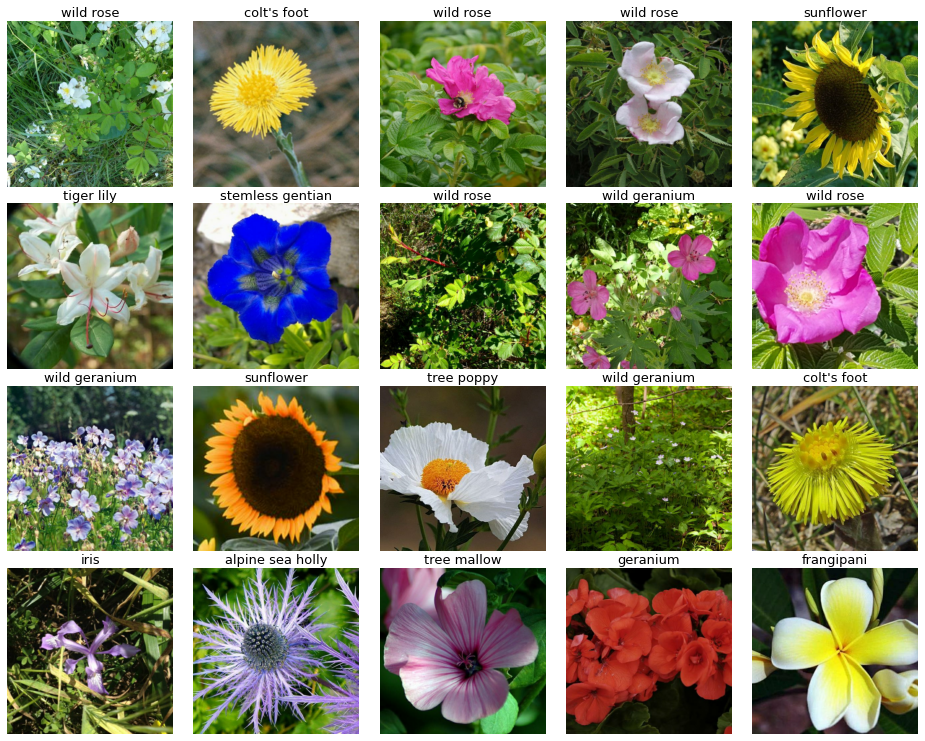

In [24]:
# Pop from batch state and display, rerun for new images
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

### Data Augmentation Visualizations ###

tuning7, show a sample of data augmented

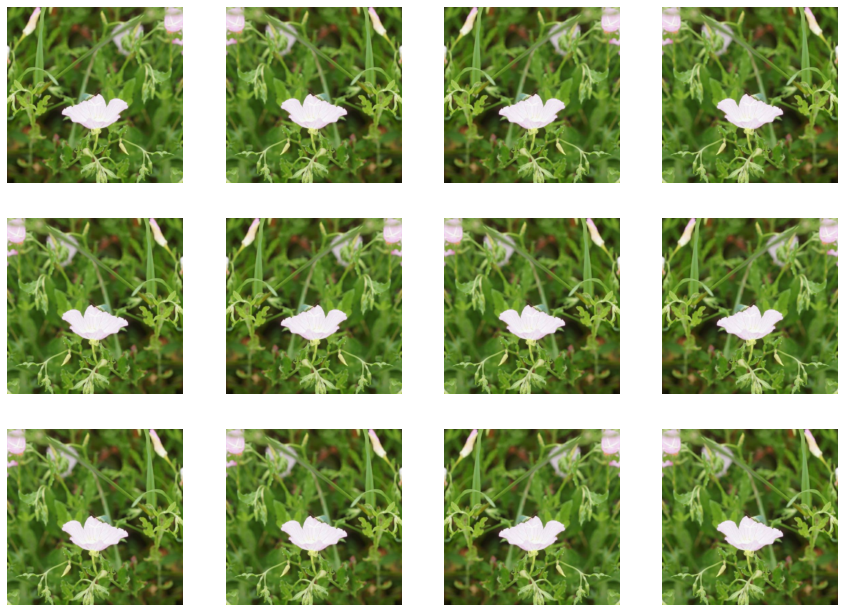

In [25]:
row = 3
col = 4
all_elements = get_training_dataset().unbatch()
one_element = tf.data.Dataset.from_tensors(next(iter(all_elements)))
# Map the images to the data augmentation function for image processing
augmented_element = one_element.repeat().map(data_augment).batch(row * col)

for (img, label) in augmented_element:
    plt.figure(figsize = (15, int(15 * row / col)))
    for j in range(row * col):
        plt.subplot(row, col, j + 1)
        plt.axis('off')
        plt.imshow(img[j, ])
    plt.show()
    break

tuning7, show a sample of data augmented v2

The cell below must be run twice inorder to work properly

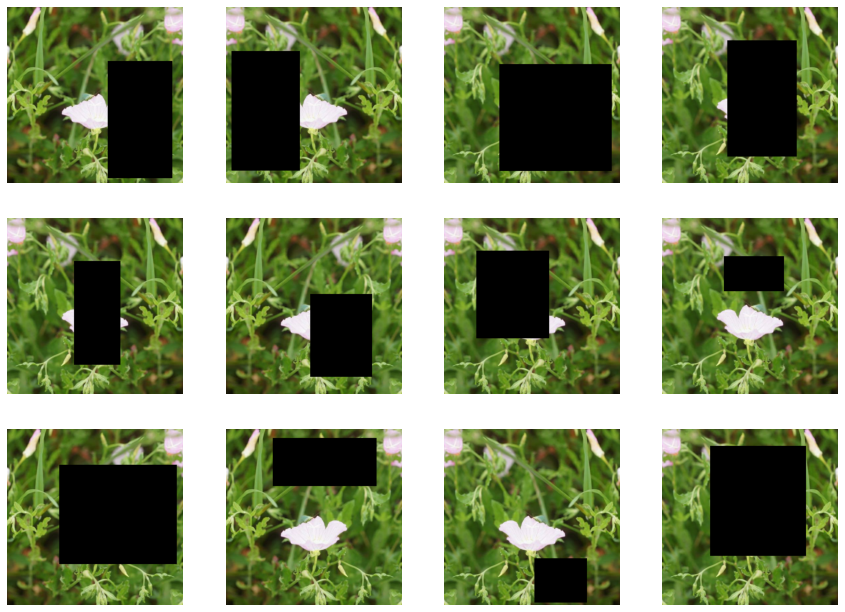

In [26]:
# Map the images to the data augmentation function for image processing
augmented_element = one_element.repeat().map(data_augment_v2).batch(row * col)

for (img, label) in augmented_element:
    plt.figure(figsize = (15, int(15 * row / col)))
    for j in range(row * col):
        plt.subplot(row, col, j + 1)
        plt.axis('off')
        plt.imshow(img[j, ])
    plt.show()
    break

tuning7, show a sample of data augmented v3

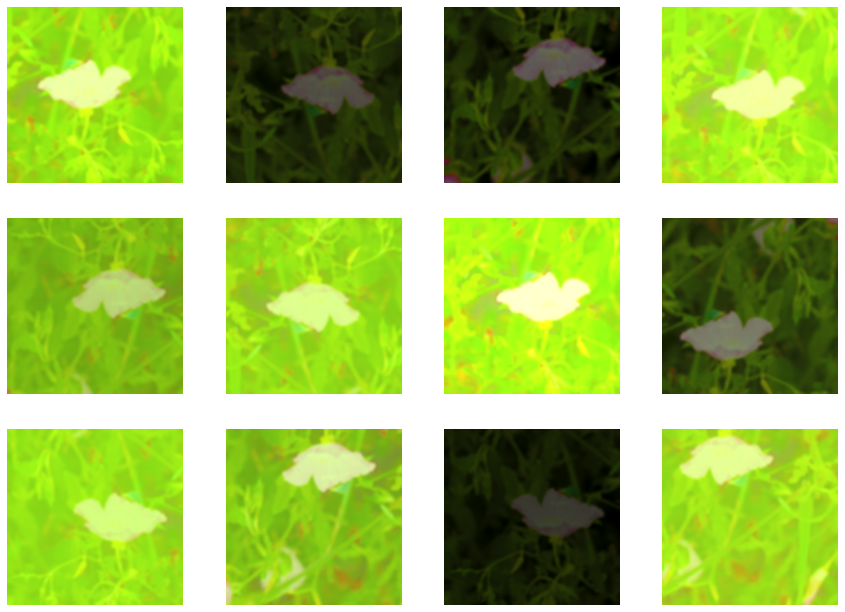

In [27]:
# Map the images to the data augmentation function for image processing
augmented_element = one_element.repeat().map(data_augment_v3).batch(row * col)

for (img, label) in augmented_element:
    plt.figure(figsize = (15, int(15 * row / col)))
    for j in range(row * col):
        plt.subplot(row, col, j + 1)
        plt.axis('off')
        plt.imshow(img[j, ])
    plt.show()
    break

# 6. Modeling #

In [28]:
EPOCHS = 20 # Change for Real Submissions Training
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

### Learning Rate Schedulers ###

Learning rate schedule: 1e-05 to 0.0004 to 2.72e-05


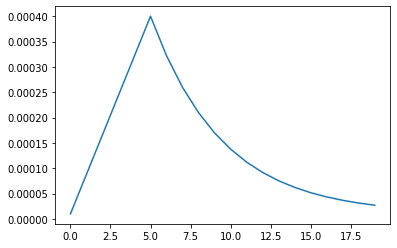

In [29]:
LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

Learning rate schedule: 0.2 to 0.2 to 0.00173


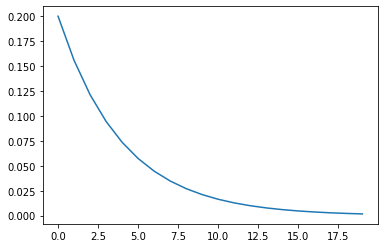

In [30]:
# lr factors
discountFactor = 0.25
beginningRate = 0.2

def schedule(epoch):
    def lr(epoch, beginningRate, discountFactor):
        return beginningRate * math.exp((-discountFactor) * epoch)
    return lr(epoch, beginningRate, discountFactor)

rng = [i for i in range(EPOCHS)]
y = [schedule(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [31]:
lrReducer = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 3, min_lr = 0.0001)

In [32]:
# LR Schedulers:
# lfrn, schedule, lrReducer

# lfrn appears to be the best scheduler

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

### Designing Models ###
From here, Rosa's notebook

In [33]:
# watch out for overfitting!
SKIP_VALIDATION = False

if SKIP_VALIDATION:
    TRAINING_FILENAMES = TRAINING_FILENAMES + VALIDATION_FILENAMES

## Model 0 ##

The below model was commented out to reduce necessary training times on thi TPU based Model

In [34]:
# Need this line so Google will recite some incantations
# for Turing to magically load the model onto the TPU
'''
with strategy.scope():
    vgg19 = tf.keras.applications.VGG19(input_shape = (VAL, VAL, 3), weights = 'imagenet', include_top = False)

    Model_0 = tf.keras.Sequential([vgg19, tf.keras.layers.GlobalAveragePooling2D(), tf.keras.layers.Dense(len(CLASSES), activation = 'softmax')])
        
    Model_0.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.0001), loss = 'sparse_categorical_crossentropy', 
                  metrics = ['val_sparse_categorical_accuracy'])
    
Model_0.summary()
'''

"\nwith strategy.scope():\n    vgg19 = tf.keras.applications.VGG19(input_shape = (VAL, VAL, 3), weights = 'imagenet', include_top = False)\n\n    Model_0 = tf.keras.Sequential([vgg19, tf.keras.layers.GlobalAveragePooling2D(), tf.keras.layers.Dense(len(CLASSES), activation = 'softmax')])\n        \n    Model_0.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.0001), loss = 'sparse_categorical_crossentropy', \n                  metrics = ['val_sparse_categorical_accuracy'])\n    \nModel_0.summary()\n"

In [35]:
# tf.keras.utils.plot_model(Model_0, show_shapes = True, show_layer_names = True)

In [36]:
# with strategy.scope():
#     Model_0_History = Model_0.fit(get_training_dataset(), steps_per_epoch = STEPS_PER_EPOCH, epochs = EPOCHS,
#                          callbacks = [lr_callback], validation_data = get_validation_dataset())

In [37]:
#if not SKIP_VALIDATION:
#    display_training_curves(Model_0_History.history['loss'], Model_0_History.history['val_loss'], 'loss', 211)
#    display_training_curves(Model_0_History.history['sparse_categorical_accuracy'], 
#                            Model_0_History.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

## Model 1 ##

In [38]:
# Need this line so Google will recite some incantations
# for Turing to magically load the model onto the TPU
with strategy.scope():
    enet = efn.EfficientNetB7(input_shape = (VAL, VAL, 3), weights = 'noisy-student', include_top = False)

    Model_1 = tf.keras.Sequential([enet, tf.keras.layers.GlobalAveragePooling2D(), tf.keras.layers.Dense(len(CLASSES), activation = 'softmax')])
        
    Model_1.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.0001), loss = 'sparse_categorical_crossentropy', 
                  metrics = ['sparse_categorical_accuracy'])
    
Model_1.summary()

258072576/258068648 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 16, 16, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               266344    
Total params: 64,364,024
Trainable params: 64,053,304
Non-trainable params: 310,720
_________________________________________________________________


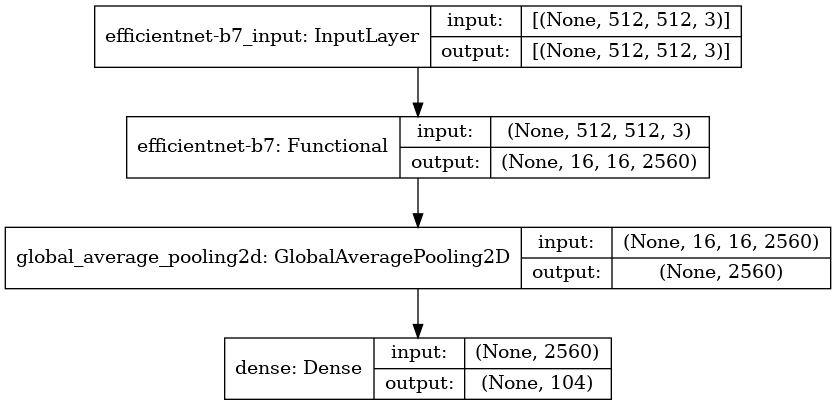

In [39]:
tf.keras.utils.plot_model(Model_1, show_shapes = True, show_layer_names = True)

In [40]:
with strategy.scope():
    Model_1_History = Model_1.fit(get_training_dataset(), steps_per_epoch = STEPS_PER_EPOCH, epochs = EPOCHS,
                          callbacks = [lr_callback], validation_data = get_validation_dataset())

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
531/531 [==============================] - 701s 939ms/step - loss: 4.3979 - sparse_categorical_accuracy: 0.1028 - val_loss: 3.7787 - val_sparse_categorical_accuracy: 0.2465


2022-05-12 04:14:08.554948: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 92210, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1652328848.554447859","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 92210, Output num: 0","grpc_status":3}


Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
531/531 [==============================] - 479s 902ms/step - loss: 1.9004 - sparse_categorical_accuracy: 0.5832 - val_loss: 0.7117 - val_sparse_categorical_accuracy: 0.8225
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
531/531 [==============================] - 478s 901ms/step - loss: 0.5636 - sparse_categorical_accuracy: 0.8635 - val_loss: 0.3991 - val_sparse_categorical_accuracy: 0.8992
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
531/531 [==============================] - 479s 902ms/step - loss: 0.3627 - sparse_categorical_accuracy: 0.9067 - val_loss: 0.3245 - val_sparse_categorical_accuracy: 0.9186
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
531/531 [==============================] - 481s 907ms/step - loss: 0.2939 - sparse_categorical_accuracy: 0.9225 - val_loss: 0.3261 - val_sparse_catego

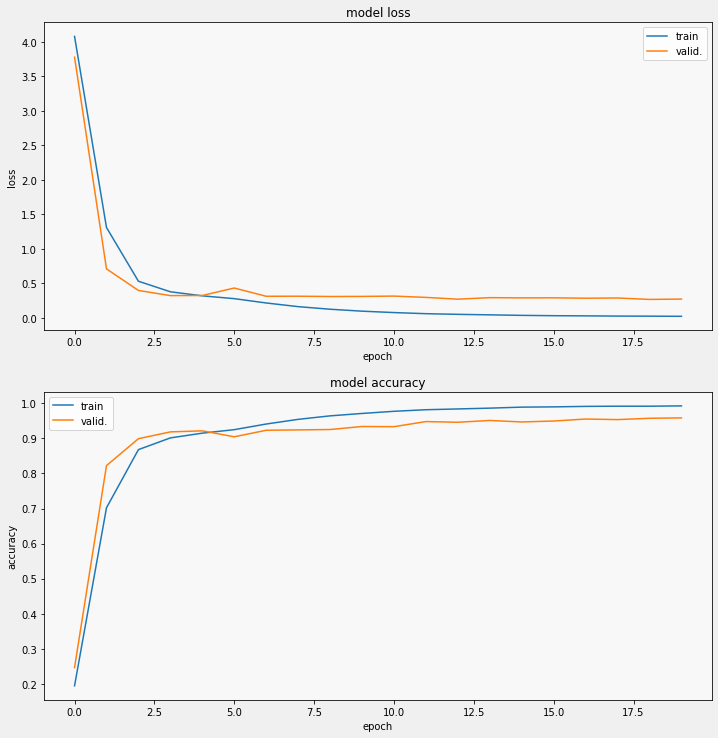

In [41]:
if not SKIP_VALIDATION:
    display_training_curves(Model_1_History.history['loss'], Model_1_History.history['val_loss'], 'loss', 211)
    display_training_curves(Model_1_History.history['sparse_categorical_accuracy'], 
                            Model_1_History.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

## Model 2 ## 

In [42]:
with strategy.scope():
    deNet = DenseNet201(input_shape = (VAL, VAL, 3), weights = 'imagenet', include_top = False)

    Model_2 = tf.keras.Sequential([deNet, tf.keras.layers.GlobalAveragePooling2D(), 
                                   tf.keras.layers.Dense(len(CLASSES), activation = 'softmax')])
    
    Model_2.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.0001), loss = 'sparse_categorical_crossentropy', 
                    metrics = ['sparse_categorical_accuracy'])
Model_2.summary()

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 16, 16, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 104)               199784    
Total params: 18,521,768
Trainable params: 18,292,712
Non-trainable params: 229,056
_________________________________________________________________


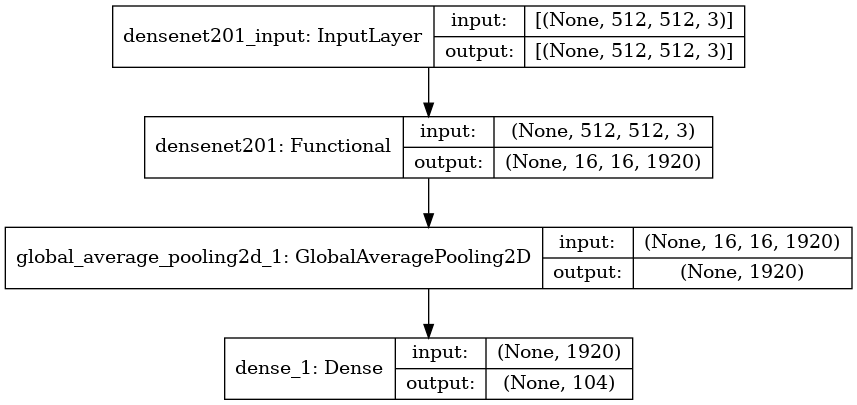

In [43]:
tf.keras.utils.plot_model(Model_2, show_shapes = True, show_layer_names = True)

In [44]:
with strategy.scope():
    Model_2_History = Model_2.fit(get_training_dataset(), steps_per_epoch = STEPS_PER_EPOCH, epochs = EPOCHS, 
                          callbacks = [lr_callback], validation_data = get_validation_dataset())

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
531/531 [==============================] - 459s 546ms/step - loss: 3.4386 - sparse_categorical_accuracy: 0.2979 - val_loss: 2.1005 - val_sparse_categorical_accuracy: 0.5733


2022-05-12 06:54:57.741466: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 242193, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1652338497.741189191","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 242193, Output num: 1","grpc_status":3}


Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
531/531 [==============================] - 270s 508ms/step - loss: 1.0219 - sparse_categorical_accuracy: 0.7787 - val_loss: 0.6081 - val_sparse_categorical_accuracy: 0.8545
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
531/531 [==============================] - 268s 505ms/step - loss: 0.4220 - sparse_categorical_accuracy: 0.9047 - val_loss: 0.4379 - val_sparse_categorical_accuracy: 0.8885
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
531/531 [==============================] - 271s 510ms/step - loss: 0.3069 - sparse_categorical_accuracy: 0.9250 - val_loss: 0.5842 - val_sparse_categorical_accuracy: 0.8467
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
531/531 [==============================] - 267s 503ms/step - loss: 0.2692 - sparse_categorical_accuracy: 0.9321 - val_loss: 0.6982 - val_sparse_catego

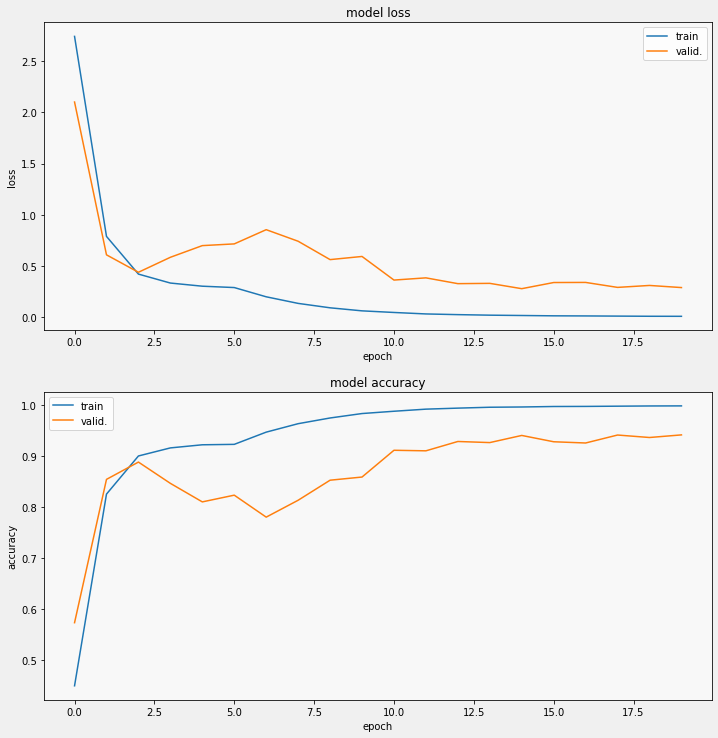

In [45]:
if not SKIP_VALIDATION:
    display_training_curves(Model_2_History.history['loss'], Model_2_History.history['val_loss'], 'loss', 211)
    display_training_curves(Model_2_History.history['sparse_categorical_accuracy'], 
                            Model_2_History.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

## Model 3 ##

In [46]:

'''
with strategy.scope():
    resNet = ResNet101V2(input_shape = (VAL, VAL, 3), weights = 'imagenet', include_top = False)

    Model_3 = tf.keras.Sequential([resNet, tf.keras.layers.GlobalAveragePooling2D(), tf.keras.layers.Dense(len(CLASSES), activation = 'softmax')])
        
    Model_3.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.0001), loss = 'sparse_categorical_crossentropy', 
                  metrics = ['sparse_categorical_accuracy'])
    
Model_3.summary()
'''

"\nwith strategy.scope():\n    resNet = ResNet101V2(input_shape = (VAL, VAL, 3), weights = 'imagenet', include_top = False)\n\n    Model_3 = tf.keras.Sequential([resNet, tf.keras.layers.GlobalAveragePooling2D(), tf.keras.layers.Dense(len(CLASSES), activation = 'softmax')])\n        \n    Model_3.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.0001), loss = 'sparse_categorical_crossentropy', \n                  metrics = ['sparse_categorical_accuracy'])\n    \nModel_3.summary()\n"

In [47]:
#tf.keras.utils.plot_model(Model_3, show_shapes = True, show_layer_names = True)

In [48]:
#with strategy.scope():
#    Model_3_History = Model_3.fit(get_training_dataset(), steps_per_epoch = STEPS_PER_EPOCH, epochs = EPOCHS, 
#                          callbacks = [lr_callback], validation_data = get_validation_dataset())

In [49]:
#if not SKIP_VALIDATION:
#    display_training_curves(Model_3_History.history['loss'], Model_3_History.history['val_loss'], 'loss', 211)
#    display_training_curves(Model_3_History.history['sparse_categorical_accuracy'], 
#                            Model_3_History.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

## Model 4 ##

In [50]:
with strategy.scope():
    Xcept = Xception(input_shape = (VAL, VAL, 3), weights = 'imagenet', include_top = False)

    Model_4 = tf.keras.Sequential([Xcept, tf.keras.layers.GlobalAveragePooling2D(), tf.keras.layers.Dense(len(CLASSES), activation = 'softmax')])
        
    Model_4.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.0001), loss = 'sparse_categorical_crossentropy', 
                  metrics = ['sparse_categorical_accuracy'])
    
Model_4.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 104)               213096    
Total params: 21,074,576
Trainable params: 21,020,048
Non-trainable params: 54,528
_________________________________________________________________


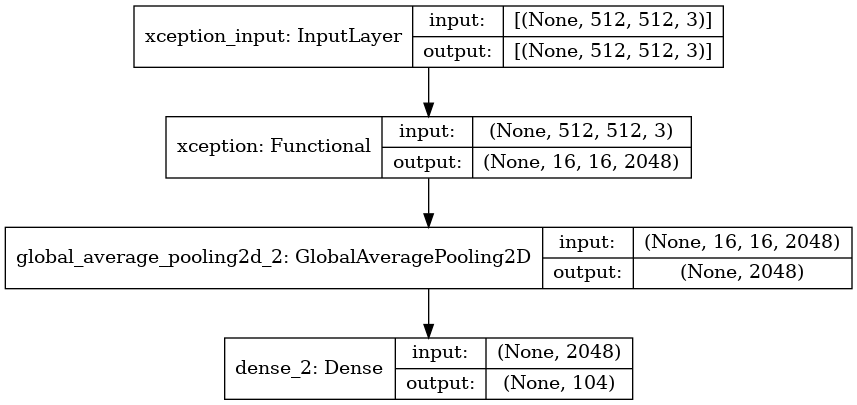

In [51]:
tf.keras.utils.plot_model(Model_4, show_shapes = True, show_layer_names = True)

In [52]:
with strategy.scope():
    Model_4_History = Model_4.fit(get_training_dataset(), steps_per_epoch = STEPS_PER_EPOCH, epochs = EPOCHS, 
                          callbacks = [lr_callback], validation_data = get_validation_dataset())

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
531/531 [==============================] - 232s 349ms/step - loss: 4.0199 - sparse_categorical_accuracy: 0.2008 - val_loss: 2.8480 - val_sparse_categorical_accuracy: 0.4100


2022-05-12 08:26:49.918946: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 328786, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1652344009.918500213","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 328786, Output num: 0","grpc_status":3}


Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
531/531 [==============================] - 182s 342ms/step - loss: 1.4418 - sparse_categorical_accuracy: 0.6877 - val_loss: 0.7631 - val_sparse_categorical_accuracy: 0.8163
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
531/531 [==============================] - 176s 332ms/step - loss: 0.4675 - sparse_categorical_accuracy: 0.8915 - val_loss: 0.5414 - val_sparse_categorical_accuracy: 0.8664
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
531/531 [==============================] - 175s 330ms/step - loss: 0.2567 - sparse_categorical_accuracy: 0.9363 - val_loss: 0.5116 - val_sparse_categorical_accuracy: 0.8801
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
531/531 [==============================] - 175s 329ms/step - loss: 0.1923 - sparse_categorical_accuracy: 0.9523 - val_loss: 0.5021 - val_sparse_catego

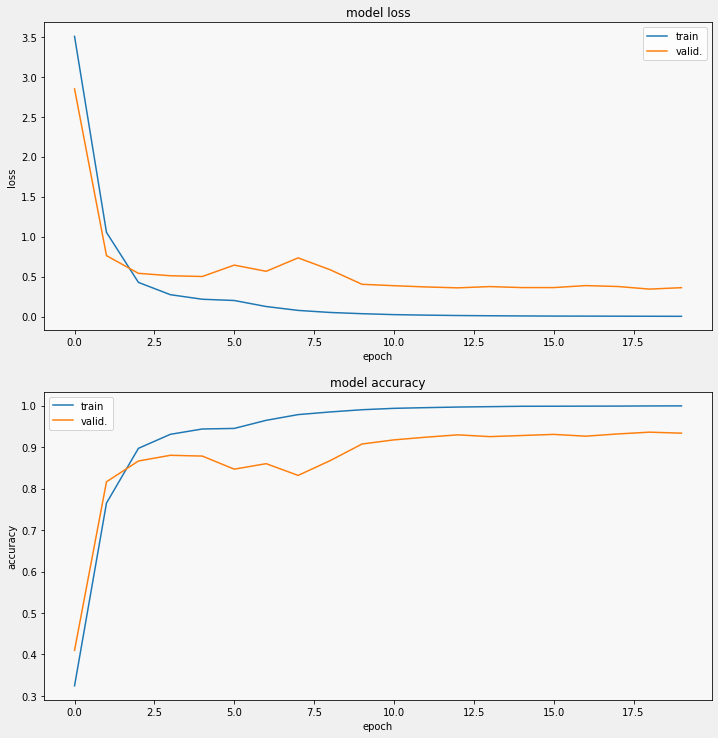

In [53]:
if not SKIP_VALIDATION:
    display_training_curves(Model_4_History.history['loss'], Model_4_History.history['val_loss'], 'loss', 211)
    display_training_curves(Model_4_History.history['sparse_categorical_accuracy'], 
                            Model_4_History.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

## Best Model ##

In [54]:
# The best model will consist of an ensembled committee of models. The most common answer of the ensemble will become the final answer.

### Validation Accuracy Visualization ### 

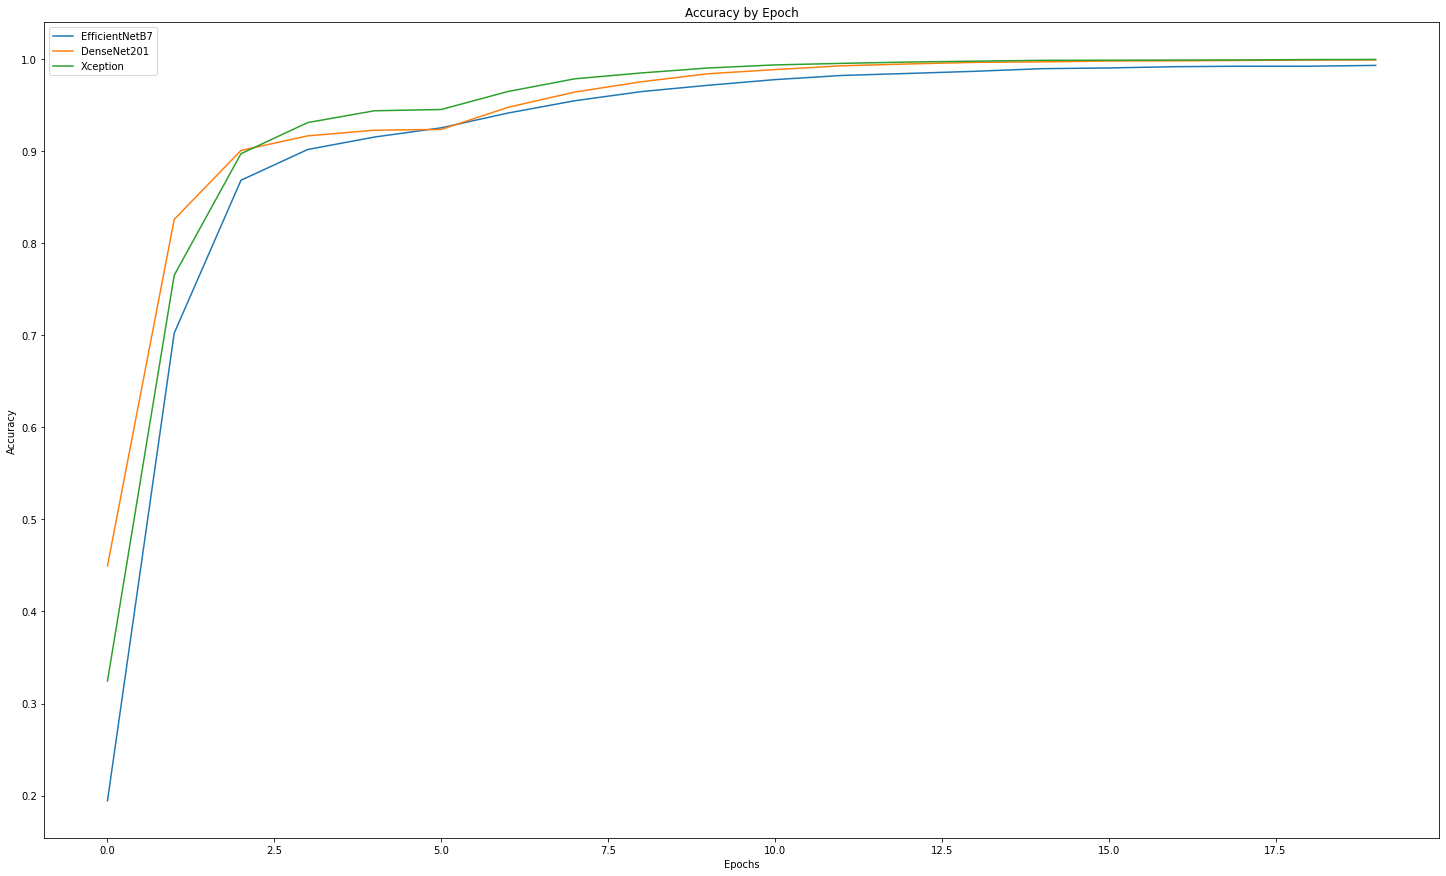

In [55]:
plt.figure(figsize = (25, 15))
# plt.plot(Model_0_History.history['val_sparse_categorical_accuracy'], label = "VGG19")
plt.plot(Model_1_History.history['sparse_categorical_accuracy'], label = "EfficientNetB7")
plt.plot(Model_2_History.history['sparse_categorical_accuracy'], label = "DenseNet201")
#plt.plot(Model_3_History.history['sparse_categorical_accuracy'], label = "ResNet101V2")
plt.plot(Model_4_History.history['sparse_categorical_accuracy'], label = "Xception")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy by Epoch")
plt.legend()
plt.show()

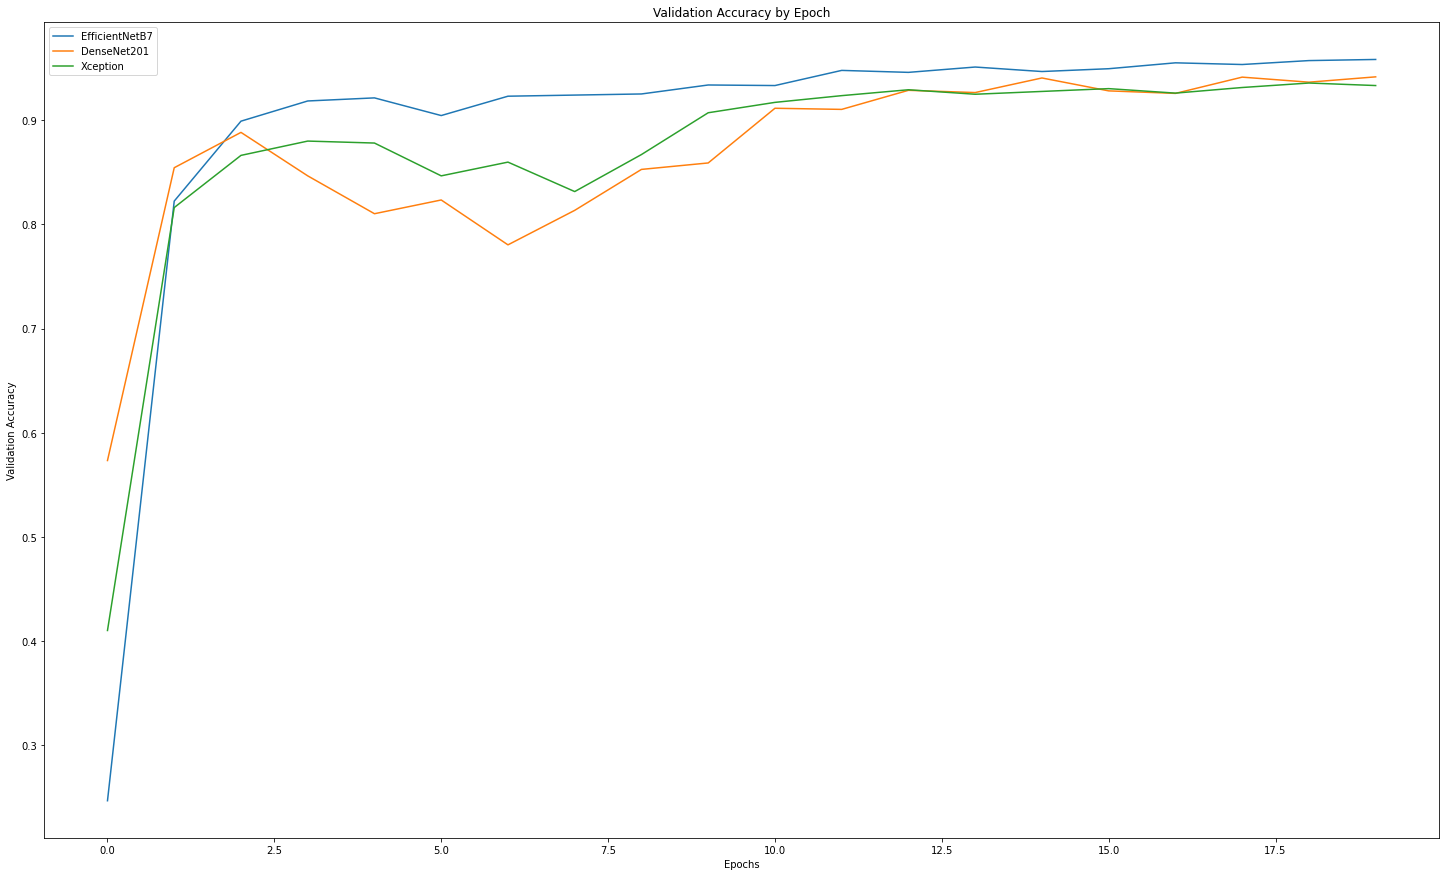

In [56]:
plt.figure(figsize = (25, 15))
# plt.plot(Model_0_History.history['val_sparse_categorical_accuracy'], label = "VGG19")
plt.plot(Model_1_History.history['val_sparse_categorical_accuracy'], label = "EfficientNetB7")
plt.plot(Model_2_History.history['val_sparse_categorical_accuracy'], label = "DenseNet201")
#plt.plot(Model_3_History.history['val_sparse_categorical_accuracy'], label = "ResNet101V2")
plt.plot(Model_4_History.history['val_sparse_categorical_accuracy'], label = "Xception")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy by Epoch")
plt.legend()
plt.show()

In [57]:
#plt.plot(Model_1_History.history['val_sparse_categorical_accuracy'], label = "EfficientNetB7") REPLACE WITH BEST MODEL
#plt.xlabel("Epochs")
#plt.ylabel("Validation Accuracy")
#plt.title("Validation Accuracy by Epoch")
#plt.legend()
#plt.show()

# 7. Validation #

Finding best alpha
Our final model is just mix of two presented above. In the first commit it was arithmetic mean (alpha = 0.5). Note that using validation data as training will fit your model with accuracy equal 1.0. Thus formula presented below of linear combination of models will work only with validation data:

prob = alpha prob(model) + (1 - alpha) prob(model2)

2022-05-12 09:26:35.249258: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 392085, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1652347595.248547718","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 392085, Output num: 0","grpc_status":3}


Correct   labels:  (3712,) [ 50  13  74 ... 102  48  67]
Predicted labels:  (3712,) [ 50  13  74 ... 102  48  67]


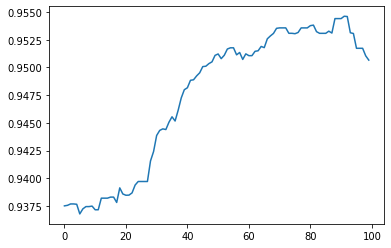

In [58]:
if not SKIP_VALIDATION:
    cmdataset = get_validation_dataset(ordered = True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
    images_ds = cmdataset.map(lambda image, label: image)
    labels_ds = cmdataset.map(lambda image, label: label).unbatch()
    cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
    Model_1_Predictions = Model_1.predict(images_ds)
    Model_2_Predictions = Model_2.predict(images_ds)
    scores = []
    for alpha in np.linspace(0, 1, 100):
        cm_probabilities = alpha * Model_1_Predictions + (1 - alpha) * Model_2_Predictions
        cm_predictions = np.argmax(cm_probabilities, axis = -1)
        scores.append(f1_score(cm_correct_labels, cm_predictions, labels = range(len(CLASSES)), average = 'macro'))
        
    print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
    print("Predicted labels: ", cm_predictions.shape, cm_predictions)
    plt.plot(scores)
    best_alpha = np.argmax(scores) / 100
    cm_probabilities = best_alpha * Model_1_Predictions + (1 - best_alpha) * Model_2_Predictions
    cm_predictions = np.argmax(cm_probabilities, axis = -1)
else:
    best_alpha = 0.51

In [59]:
print(best_alpha)

0.91


Mismatches on a validation data

In [60]:
'''
if not SKIP_VALIDATION:
    
    cmdataset_with_id = get_validation_dataset_with_id(ordered=True)
    ids_ds = cmdataset_with_id.map(lambda image, label, idnum: idnum).unbatch()
    ids = next(iter(ids_ds.batch(NUM_VALIDATION_IMAGES))).numpy().astype('U') # get everything as one batch

    val_batch = iter(cmdataset.unbatch().batch(1))
    noip = sum(cm_predictions != cm_correct_labels)
    print('Number of incorrect predictions: ' + str(noip) + ' (' + str(round(noip / NUM_VALIDATION_IMAGES * 100,1)) + '%)')
    for fi in range(NUM_VALIDATION_IMAGES):
        x = next(val_batch)
        if cm_predictions[fi] != cm_correct_labels[fi]:
            print("Image id: '" + ids[fi] + "'")
            display_batch_of_images(x,np.array([cm_predictions[fi]]),figsize = 2)
'''

'\nif not SKIP_VALIDATION:\n    \n    cmdataset_with_id = get_validation_dataset_with_id(ordered=True)\n    ids_ds = cmdataset_with_id.map(lambda image, label, idnum: idnum).unbatch()\n    ids = next(iter(ids_ds.batch(NUM_VALIDATION_IMAGES))).numpy().astype(\'U\') # get everything as one batch\n\n    val_batch = iter(cmdataset.unbatch().batch(1))\n    noip = sum(cm_predictions != cm_correct_labels)\n    print(\'Number of incorrect predictions: \' + str(noip) + \' (\' + str(round(noip / NUM_VALIDATION_IMAGES * 100,1)) + \'%)\')\n    for fi in range(NUM_VALIDATION_IMAGES):\n        x = next(val_batch)\n        if cm_predictions[fi] != cm_correct_labels[fi]:\n            print("Image id: \'" + ids[fi] + "\'")\n            display_batch_of_images(x,np.array([cm_predictions[fi]]),figsize = 2)\n'

Confusion matrix

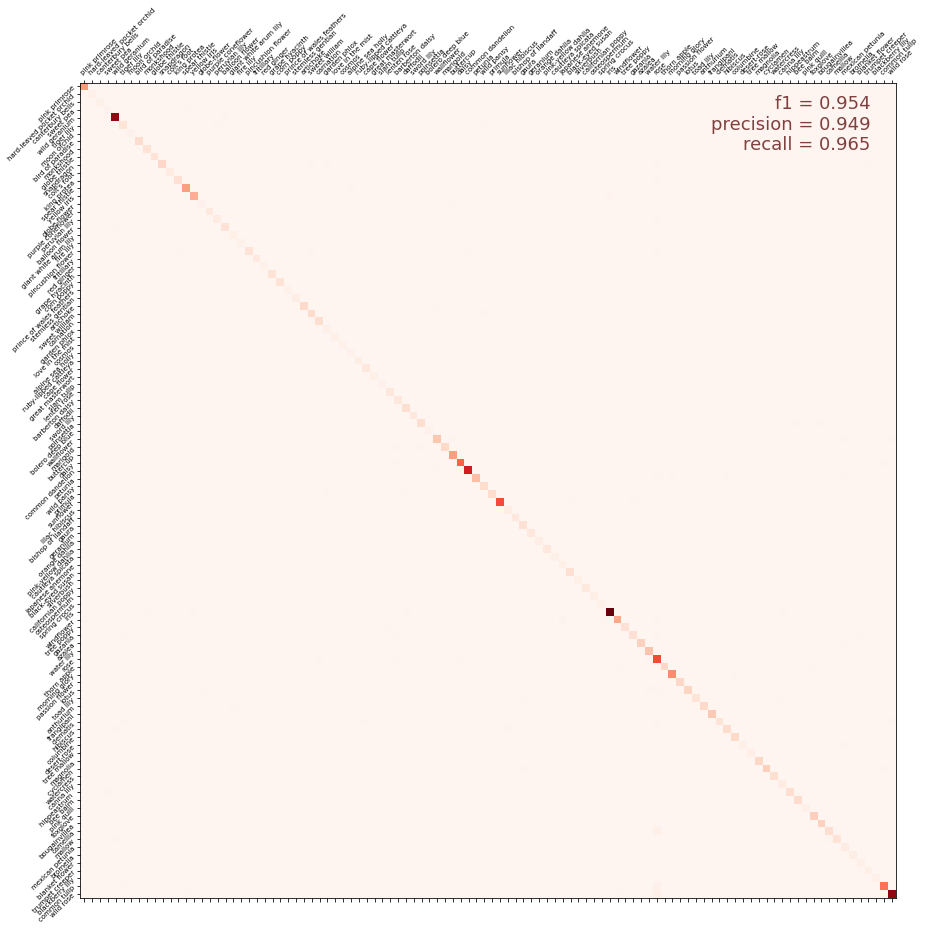

f1 score: 0.954, precision: 0.949, recall: 0.965


In [61]:
if not SKIP_VALIDATION:
    cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels = range(len(CLASSES)))
    score = f1_score(cm_correct_labels, cm_predictions, labels = range(len(CLASSES)), average = 'macro')
    precision = precision_score(cm_correct_labels, cm_predictions, labels = range(len(CLASSES)), average = 'macro')
    recall = recall_score(cm_correct_labels, cm_predictions, labels = range(len(CLASSES)), average = 'macro')
    #cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
    display_confusion_matrix(cmat, score, precision, recall)
    print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

# 8. Submission of Predictions #

In [62]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
# probabilities = best_alpha * Model_1.predict(test_images_ds) + (1-best_alpha) * Model_2.predict(test_images_ds)
probabilities = (0.334 * Model_1.predict(test_images_ds)) + (0.333 * Model_2.predict(test_images_ds)) + (0.333 * Model_4.predict(test_images_ds))
# We ignore VGG model as it is significantly worse than the rest
predictions = np.argmax(probabilities, axis = -1)
print(predictions)

print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt = ['%s', '%d'], 
           delimiter = ',', header = 'id,label', comments = '')

Computing predictions...


2022-05-12 09:29:59.322394: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 392766, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1652347799.322232499","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 392766, Output num: 0","grpc_status":3}


[ 67  28  83 ...  95 102  62]
Generating submission.csv file...


# 9. Visualizing the Predictions

In [63]:
mismatches = sum(cm_predictions!=cm_correct_labels)
print('Number of mismatches on validation data: {} out of {} or ({:.2%})'.format(mismatches, NUM_VALIDATION_IMAGES, mismatches/NUM_VALIDATION_IMAGES))

Number of mismatches on validation data: 148 out of 3712 or (3.99%)


In [64]:
validation_dataset = ds_valid
validation_dataset = validation_dataset.unbatch().batch(20)
batch = iter(validation_dataset)

In [65]:
images, labels = next(batch)

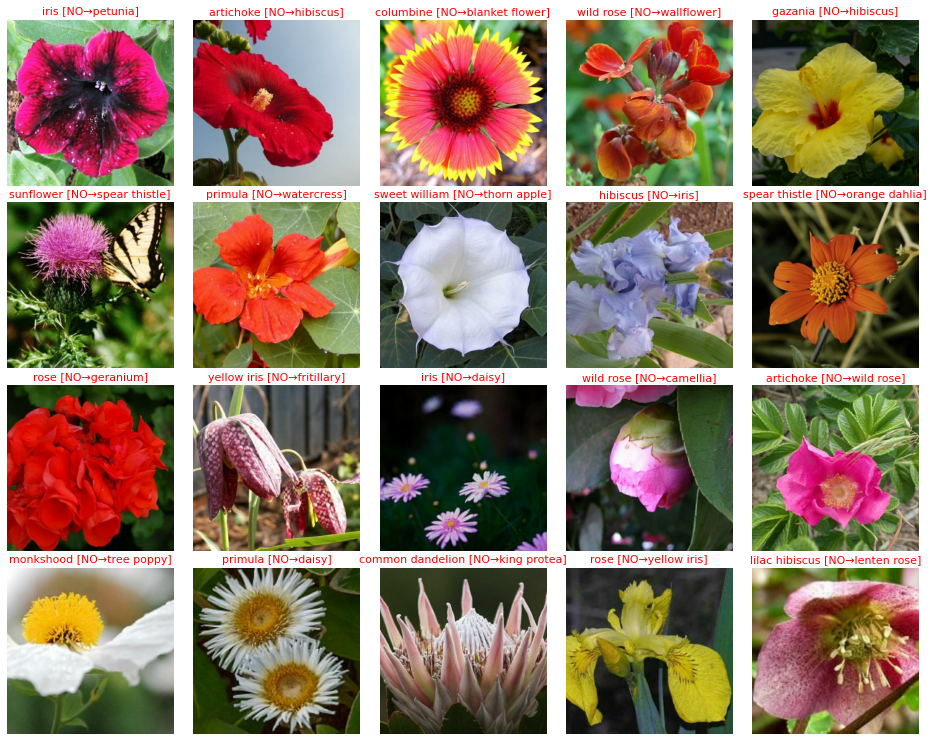

In [66]:
predictions = np.argmax( probabilities, axis = -1 )
display_batch_of_images((images, labels), predictions)